## ThinkDSP

This notebook contains solutions to exercises in Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## Exercise 1

In this chapter I claim that `analyze1` takes time proportional
to $n^3$ and `analyze2` takes time proportional to $n^2$.  To
see if that's true, run them on a range of input sizes and time
them.  In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you
should get a straight line with slope 3 for  `analyze1` and
slope 2 for `analyze2`.  You also might want to test `dct_iv`
and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [3]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [4]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [5]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Works for the general case where M is not orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [6]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

Here are the results for `analyze1`.

In [7]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096])

64
270 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
834 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
3.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
18 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
75.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
343 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1523010349686165

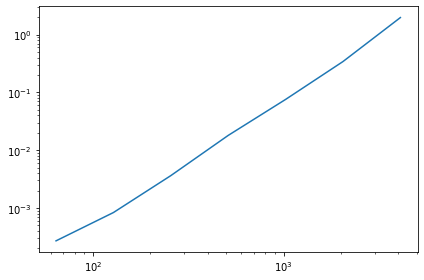

In [8]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

The estimated slope is close to 2, not 3, as expected.  One possibility is that the performance of `np.linalg.solve` is nearly quadratic in this range of array sizes.

Here are the results for `analyze2`:

In [9]:
def analyze2(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Assumes that fs and ts are chosen so that M is orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    

    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
171 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
670 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.58 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
10.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
45.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
165 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
625 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.9837162383836813

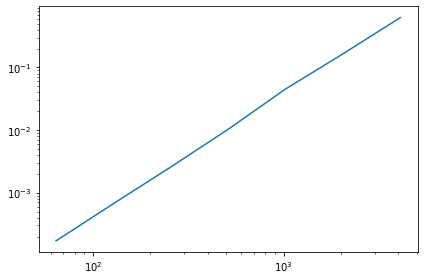

In [10]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

The results for `analyze2` fall in a straight line with the estimated slope close to 2, as expected.

Here are the results for the `scipy.fftpack.dct`

In [11]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
7.02 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
8.33 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
8.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
9.42 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
13.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
24.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
41.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.4112565850438262

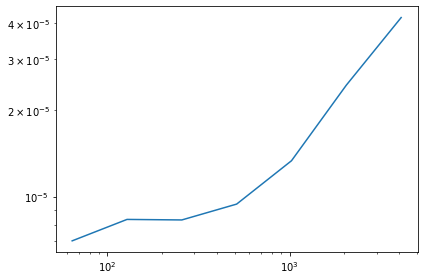

In [12]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

This implementation of dct is even faster.  The line is curved, which means either we haven't seen the asymptotic behavior yet, or the asymptotic behavior is not a simple exponent of $n$.  In fact, as we'll see soon, the run time is proportional to $n \log n$.

The following figure shows all three curves on the same axes.

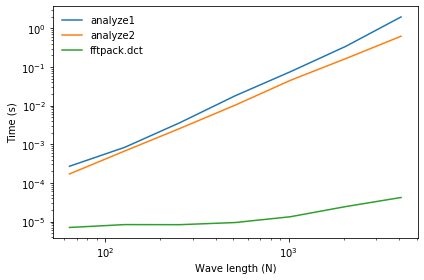

In [13]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

## Exercise 2

One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [14]:
if not os.path.exists('100475__iluppai__saxophone-weep.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav

In [7]:
from thinkdsp import read_wave

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Here's a short segment:

In [8]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

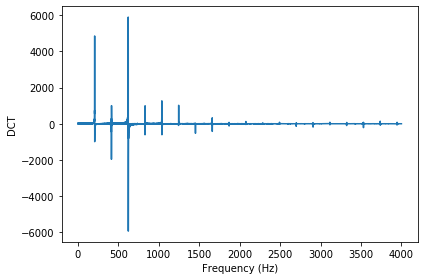

In [17]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

There are only a few harmonics with substantial amplitude, and many entries near zero.

The following function takes a DCT and sets elements below `thresh` to 0.

In [10]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

If we apply it to the segment, we can eliminate more than 90% of the elements:

22037	22050	99.94104308390023


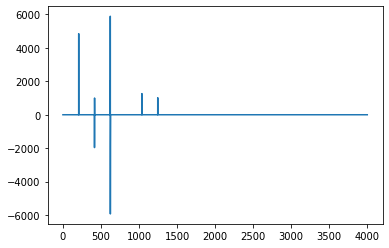

In [15]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=1000)
seg_dct.plot(high=4000)

And the result sounds the same (at least to me):

In [16]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

To compress a longer segment, we can make a DCT spectrogram.  The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [19]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Now we can make a DCT spectrogram and apply `compress` to each segment:

In [42]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
print(len(wave))
for idx, (t, dct) in enumerate(sorted(spectro.spec_map.items())):
    print(idx,':', end='')
    compress(dct, thresh=200)

517889
0 :1024	1024	100.0
1 :1024	1024	100.0
2 :1024	1024	100.0
3 :1024	1024	100.0
4 :1024	1024	100.0
5 :1024	1024	100.0
6 :1024	1024	100.0
7 :1024	1024	100.0
8 :1024	1024	100.0
9 :1024	1024	100.0
10 :1024	1024	100.0
11 :1024	1024	100.0
12 :1024	1024	100.0
13 :1024	1024	100.0
14 :1024	1024	100.0
15 :1024	1024	100.0
16 :1024	1024	100.0
17 :1024	1024	100.0
18 :1024	1024	100.0
19 :1024	1024	100.0
20 :1024	1024	100.0
21 :1024	1024	100.0
22 :1024	1024	100.0
23 :1024	1024	100.0
24 :1024	1024	100.0
25 :1024	1024	100.0
26 :1024	1024	100.0
27 :1024	1024	100.0
28 :1024	1024	100.0
29 :1024	1024	100.0
30 :1024	1024	100.0
31 :1024	1024	100.0
32 :1024	1024	100.0
33 :1024	1024	100.0
34 :1024	1024	100.0
35 :1024	1024	100.0
36 :1024	1024	100.0
37 :1024	1024	100.0
38 :1024	1024	100.0
39 :1024	1024	100.0
40 :1024	1024	100.0
41 :1024	1024	100.0
42 :1024	1024	100.0
43 :1024	1024	100.0
44 :1024	1024	100.0
45 :1024	1024	100.0
46 :1024	1024	100.0
47 :1024	1024	100.0
48 :1024	1024	100.0
49 :1024	1024	100.0
50 

In most segments, the compression is 75-85%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [41]:
wave2 = spectro.make_wave()
wave2.make_audio()

And here's the original again for comparison.

In [22]:
wave.make_audio()

As an experiment, you might try increasing `thresh` to see when the effect of compression becomes audible (to you).

Also, you might try compressing a signal with some noisy elements, like cymbals.